<a href="https://colab.research.google.com/github/p25-c4/kurly_project/blob/main/0320_SG_%EB%B0%B0%EC%86%A1%EC%A7%80%EC%97%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 배송지연 분석

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 한글폰트 설정
mpl.rc("font",family = "NanumGothic")
mpl.rc("axes", unicode_minus = False)

In [ ]:
import matplotlib.colors as mcolors
# 시작 색상
start_color = mcolors.hex2color("#6A0096")  # RGB 형태로 변환
# 팔레트 생성을 위한 함수
def create_gradient(start_color, n=7):
    palette = [start_color]
    for i in range(1, n):
        new_color = (
            start_color[0] + (1 - start_color[0]) / n * i,
            start_color[1] + (1 - start_color[1]) / n * i,
            start_color[2] + (1 - start_color[2]) / n * i,
        )
        palette.append(new_color)
    return palette
# 7개의 보라색 팔레트 생성
purple_palette = create_gradient(start_color, n=7)

In [ ]:
import os
os.chdir("/content/drive/MyDrive/BigData/early_project")

## Data load

In [ ]:
kurly.groupby("Year")['Delay_YN'].mean()

Year
2021    0.039529
2022    0.039181
2023    0.037831
Name: Delay_YN, dtype: float64

In [ ]:
kurly = pd.read_csv("kurly.csv")
kurly.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined,Weekday,WeekdayName,Cluster
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성",4,Friday,0
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성",4,Friday,0
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성",4,Friday,0
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성",4,Friday,0
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성",4,Friday,0


In [ ]:
# 날짜데이터들 형식 변경
kurly['Date'] = pd.to_datetime(kurly['Date'])
kurly['DeliveryDT'] = pd.to_datetime(kurly['DeliveryDT'])
kurly['OrderDT'] = pd.to_datetime(kurly['OrderDT'])

kurly['Date_Delivery'] = pd.to_datetime(kurly['DeliveryDT'].dt.strftime('%Y-%m-%d')) # 도착날짜 연-월-일 형식으로 추가
kurly['Delivery_diff_Order'] = kurly['Date_Delivery'] - kurly['Date'] # 도착날짜 - 주문날짜(days)
kurly[['OrderDT', 'DeliveryDT', 'Delivery_diff_Order']].head()

,OrderDT,DeliveryDT,Delivery_diff_Order
0,2021-12-03 20:59:27,2021-12-04 03:26:00,1 days
1,2021-12-03 20:59:27,2021-12-04 03:26:00,1 days
2,2021-12-03 20:59:27,2021-12-04 03:26:00,1 days
3,2021-12-03 20:59:27,2021-12-04 03:26:00,1 days
4,2021-12-03 20:59:27,2021-12-04 03:26:00,1 days


In [ ]:
# 배송 요일 추가
# 요일 추출 (월요일=0, 일요일=6)
kurly['Weekday_Delivery'] = kurly['DeliveryDT'].dt.weekday
# 숫자 요일을 문자열 요일로 매핑
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
kurly['WeekdayName_Delivery'] = kurly['Weekday_Delivery'].map(weekday_map)
# order_user = order_user.drop(columns='Weekday')

kurly[['DeliveryDT','WeekdayName_Delivery']]

,DeliveryDT,WeekdayName_Delivery
0,2021-12-04 03:26:00,Saturday
1,2021-12-04 03:26:00,Saturday
2,2021-12-04 03:26:00,Saturday
3,2021-12-04 03:26:00,Saturday
4,2021-12-04 03:26:00,Saturday
...,...,...
1018706,2023-04-12 04:36:00,Wednesday
1018707,2023-04-12 04:36:00,Wednesday
1018708,2023-04-12 04:36:00,Wednesday
1018709,2023-04-12 04:36:00,Wednesday


## 요일별 배송지연율

In [ ]:
# 전체 배송지연율
kurly['Delay_YN'].mean()

0.03870773948646868

In [ ]:
# 주문요일별 배송지연율
grouped_data = kurly.groupby('WeekdayName')['Delay_YN'].value_counts(normalize=True).rename("percentage").reset_index()
grouped_data.sort_values(by=['percentage'])

,WeekdayName,Delay_YN,percentage
1,Friday,1,0.031089
5,Saturday,1,0.036901
11,Tuesday,1,0.037983
9,Thursday,1,0.039253
7,Sunday,1,0.039575
13,Wednesday,1,0.040886
3,Monday,1,0.041560
2,Monday,0,0.958440
12,Wednesday,0,0.959114
6,Sunday,0,0.960425


In [ ]:
# 배송요일별 배송지연율
grouped_data = kurly.groupby('WeekdayName_Delivery')['Delay_YN'].value_counts(normalize=True).rename("percentage").reset_index()
grouped_data.sort_values(by=['percentage'])

,WeekdayName_Delivery,Delay_YN,percentage
5,Saturday,1,0.033247
11,Wednesday,1,0.037582
3,Monday,1,0.038706
1,Friday,1,0.039009
7,Thursday,1,0.040659
9,Tuesday,1,0.042009
8,Tuesday,0,0.957991
6,Thursday,0,0.959341
0,Friday,0,0.960991
2,Monday,0,0.961294


|   |월|화|수|목|금|토|
|---|---|---|---|---|---|---|
|배송지연율(%)|3.9|4.2|3.8|4.1|3.9|3.3|

- 토요일의 배송지연율이 낮다(약 3.3%)
- 평균(4.1%) 대비 84% 수준
- 화요일(4.36%) 대비 80% 수준


### 검정(z_test)

In [ ]:
from statsmodels.stats.weightstats import ztest

In [ ]:
## 화요일과 나머지 ztest
# WeekdayName이 Tuesday인 데이터와 아닌 데이터로 분리
delay_tuesday = kurly[kurly['WeekdayName_Delivery'] == 'Tuesday']['Delay_YN']
delay_not_tuesday = kurly[kurly['WeekdayName_Delivery'] != 'Tuesday']['Delay_YN']
# z-검정 실시
z_stat, p_value = ztest(delay_tuesday, delay_not_tuesday)
print(f'Z-statistic: {z_stat}, P-value: {p_value}')

Z-statistic: 7.345396493560436, P-value: 2.0515003630515544e-13


In [ ]:
## 목요일과 나머지 ztest
# WeekdayName이 Thursday인 데이터와 아닌 데이터로 분리
delay_thursday = kurly[kurly['WeekdayName_Delivery'] == 'Thursday']['Delay_YN']
delay_not_thursday = kurly[kurly['WeekdayName_Delivery'] != 'Thursday']['Delay_YN']
# z-검정 실시
z_stat, p_value = ztest(delay_thursday, delay_not_thursday)
print(f'Z-statistic: {z_stat}, P-value: {p_value}')

Z-statistic: 4.7197407066349895, P-value: 2.361454615346963e-06


In [ ]:
## 토요일과 나머지 ztest
# WeekdayName이 Saturday인 데이터와 아닌 데이터로 분리
delay_saturday = kurly[kurly['WeekdayName_Delivery'] == 'Saturday']['Delay_YN']
delay_not_saturday = kurly[kurly['WeekdayName_Delivery'] != 'Saturday']['Delay_YN']
# z-검정 실시
z_stat, p_value = ztest(delay_saturday, delay_not_saturday)
print(f'Z-statistic: {z_stat}, P-value: {p_value}')

Z-statistic: -11.224187509498696, P-value: 3.102247120979976e-29


|   |화요일|목요일|토요일|
|---|---|---|---|
|지연율(%)|4.2|4.1|3.3|
|z_통계량|7.35|4.72|-11.22|
|p-value|2.05e-13|2.36-06|3.10e-29|

* 유의수준 5%에서    
* 화요일, 목요일은 다른 요일에 비해 유의하게 배송지연율이 높고
* 토요일은 다른 요일에 비해 유의하게 배송지연율이 낮다.

In [ ]:
# 요일별 배송 수
weekdays = []
counts = []
for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:

    weekdays.append(weekday)
    counts.append(kurly[kurly['WeekdayName_Delivery']==weekday]['idOrder'].count())

count_weekday_delivery = pd.DataFrame({'weekday': weekdays,
                                       'count': counts})
count_weekday_delivery

,weekday,count
0,Monday,213742
1,Tuesday,156015
2,Wednesday,155075
3,Thursday,179370
4,Friday,178318
5,Saturday,136191
6,Sunday,0


Text(0.5, 1.0, '요일별 배송 수')

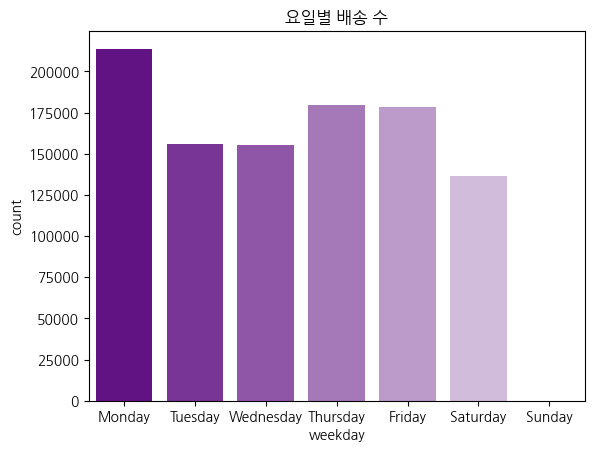

In [ ]:
# 요일별 배송 수
sns.barplot(data = count_weekday_delivery, x = 'weekday', y='count', hue='weekday', palette=purple_palette)
plt.title("요일별 배송 수")

In [ ]:
# 요일별 주문량
weekday_q = kurly.groupby('WeekdayName')['idOrder'].count().reset_index()
weekday_q

,WeekdayName,idOrder
0,Friday,126732
1,Monday,143335
2,Saturday,9539
3,Sunday,219884
4,Thursday,177005
5,Tuesday,158020
6,Wednesday,184196


Text(0.5, 1.0, '요일별 주문 수')

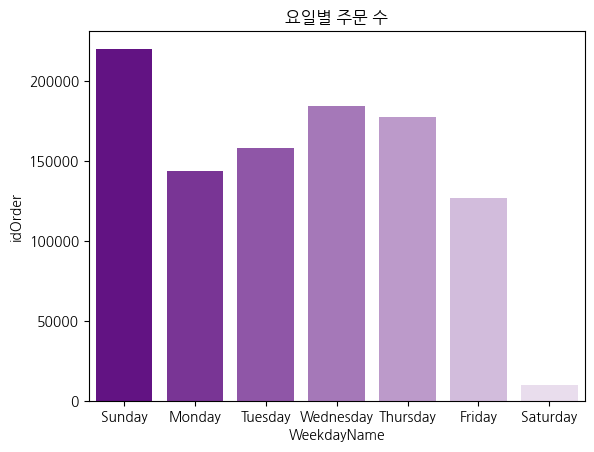

In [ ]:
sns.barplot(data=weekday_q, x='WeekdayName', y='idOrder',
             order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], hue='WeekdayName', palette=purple_palette, hue_order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.title("요일별 주문 수")

- 화요일에 배송 지연율이 높은 이유
    - 일요일 주문 많음 & 일요일 배송 안 함
    - 월요일에 배달 건 폭주
    - 감당을 못함
    - 배송이 화요일로 밀림
    - 화요일에 예상치 못한 배송량이 늘어나서 배송 지연율 증가
- 목요일에 배송 지연율이 높은 이유
    - 수요일 주문량이 많아서
- 토요일에 배송 지연율이 낮은 이유
    - 금요일 주문량이 적어서
- 그러면 왜 월요일은 배송량이 많은데 지연율이 낮은지??
    - 월요일은 토요일, 일요일 2일치의 주문을 배송함
    - 배송 기사 확보 등 많은 양의 배송을 처리할 수 있는 인프라가 구성되어있음
    - 배송량이 많을 것을 예상했기 때문에 지연율이 낮다.

- 도착 전 날 매출과는 크게 관련 없는 듯

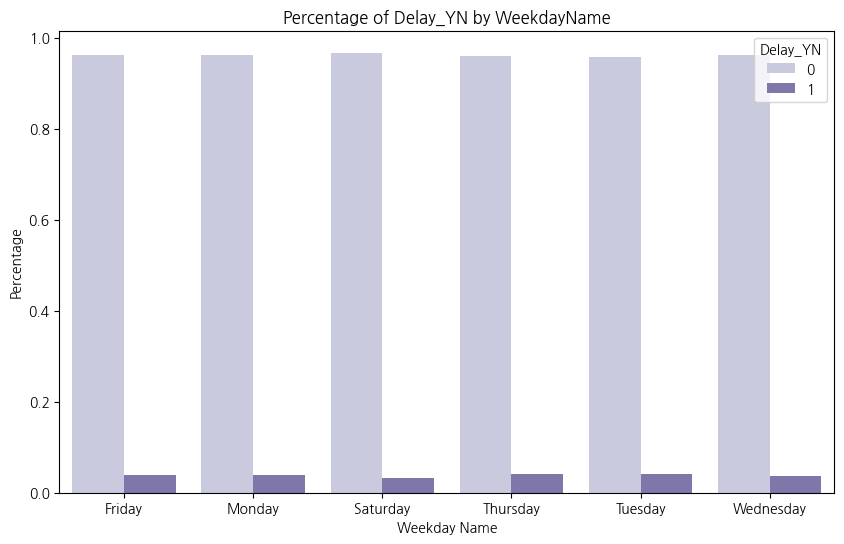

In [ ]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x="WeekdayName_Delivery", y="percentage", hue="Delay_YN", data=grouped_data, palette='Purples')
plt.title("Percentage of Delay_YN by WeekdayName")
plt.ylabel("Percentage")
plt.xlabel("Weekday Name")

plt.show()

## 시간대별 도착건수

In [ ]:
kurly.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,TimeBetweenOrders,Combined,Weekday,WeekdayName,Cluster,Date_Delivery,Delivery_diff_Order,Weekday_Delivery,WeekdayName_Delivery,Delivery_Hour
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,3 days 09:06:40,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,3 days 09:06:40,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,3 days 09:06:40,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,3 days 09:06:40,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,3 days 09:06:40,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3


In [ ]:
kurly['DeliveryHM'] = kurly['DeliveryDT'].apply(lambda x: x.strftime('%H:%M'))

In [ ]:
delivery_time = kurly.groupby('DeliveryHM')['idOrder'].count().reset_index()

Text(0, 0.5, '배송 수')

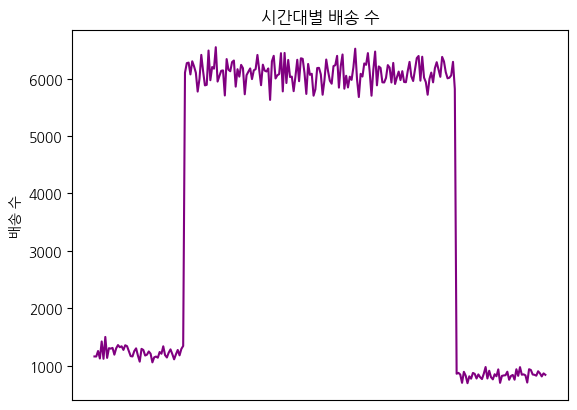

In [ ]:
sns.lineplot(data = delivery_time, x = 'DeliveryHM', y='idOrder', c='purple')
plt.gca().axes.xaxis.set_visible(False)
plt.title("시간대별 배송 수")
plt.ylabel("배송 수")

* 3~7시에 대부분이 몰려 있다,

## 주문시간별 배송지연율

In [ ]:
Hour_delay = kurly.groupby('Hour')['Delay_YN'].mean().reset_index()
Hour_delay.head()

,Hour,Delay_YN
0,0,0.036010
1,1,0.033152
2,2,0.024434
3,3,0.048292
4,4,0.034146


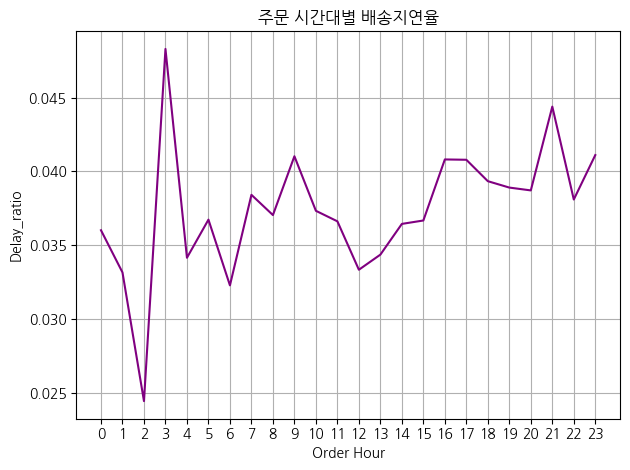

In [ ]:
# 그래프 그리기
plt.plot(Hour_delay['Hour'], Hour_delay['Delay_YN'], color='purple', linestyle='-')
# 그래프 제목과 축 레이블
plt.title('주문 시간대별 배송지연율')
plt.xlabel('Order Hour')
plt.ylabel('Delay_ratio')
# 그래프 보여주기
plt.grid(True)
plt.xticks(range(24))  # x축 눈금을 시간대로 설정
plt.tight_layout()
plt.show()

- 주문 시간별 배송지연율
    - 새벽 3~4시에 주문시 배송지연율 매우 높음
    - 총 주문건수 약 18만개 중 500개 정도로 낮아서
    - 큰 영향은 없어 보임.

- (21시 이후 주문 & 익일 7시 이후 배송을 지연이라고 판단했을 때)
    - 21~22시 주문할 경우 배송지연율이 약 7.7 %로 타 시간대보다 매우 높음




In [ ]:
# Delivery_hour 추가
kurly['Delivery_Hour'] = kurly['DeliveryDT'].dt.hour
kurly.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Combined,Weekday,WeekdayName,Cluster,Date_Delivery,Delivery_diff_Order,Weekday_Delivery,WeekdayName_Delivery,Delivery_Hour,DeliveryHM
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3,03:26
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3,03:26
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3,03:26
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3,03:26
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,"2030s, 여성",4,Friday,0,2021-12-04,1 days,5,Saturday,3,03:26


<ipython-input-81-df70cb2f2d4f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = kurly_order_21, x = 'Delivery_diff_Order', palette='Purples')


Text(0.5, 1.0, '21~22시 주문시 도착까지 걸리는 일 수')

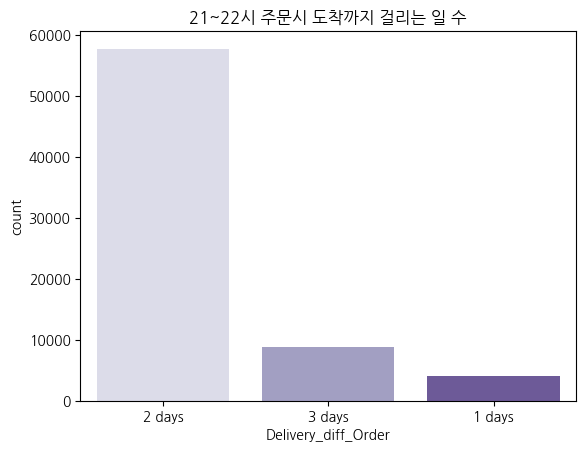

In [ ]:
kurly_order_21 = kurly[kurly['Hour']==21]
sns.countplot(data = kurly_order_21, x = 'Delivery_diff_Order', palette='Purples')
plt.title("21~22시 주문시 도착까지 걸리는 일 수")

In [ ]:
# 21시 ~ 22시 주문시 도착까지 걸리는 일 수 비율
kurly_order_21['Delivery_diff_Order'].value_counts(normalize = True)

2 days    0.817115
3 days    0.125233
1 days    0.057652
Name: Delivery_diff_Order, dtype: float64

Text(0.5, 1.0, '21~22시 주문하여 배송에 2일 걸린 경우의 배송 수')

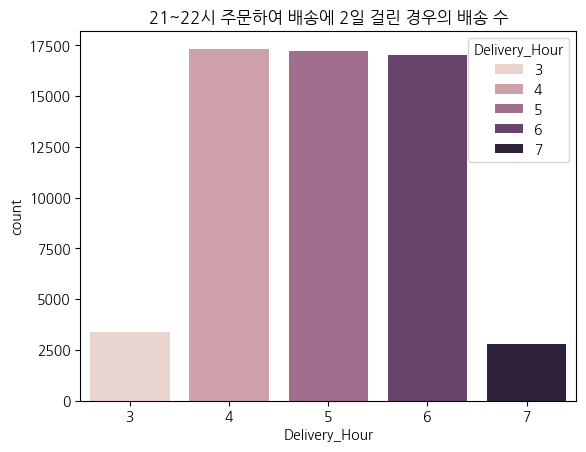

In [ ]:
# 21~22시 주문하여 배송에 2일 걸린 경우의 배송지연율 plot
sns.countplot(data = kurly_order_21[kurly_order_21['Delivery_diff_Order']=='2 days'], x = 'Delivery_Hour', hue='Delivery_Hour')
plt.title("21~22시 주문하여 배송에 2일 걸린 경우의 배송 수")

In [ ]:
# 21~22시 주문하여 배송에 2일 걸린 경우의 배송지연율
kurly_order_21[kurly_order_21['Delivery_diff_Order']=='2 days']['Delivery_Hour'].value_counts(normalize=True)

4    0.300087
5    0.298494
6    0.294842
3    0.058421
7    0.048156
Name: Delivery_Hour, dtype: float64

Text(0.5, 1.0, '21~22시 주문하여 배송에 1일 걸린 경우의 시간대별 배송 수')

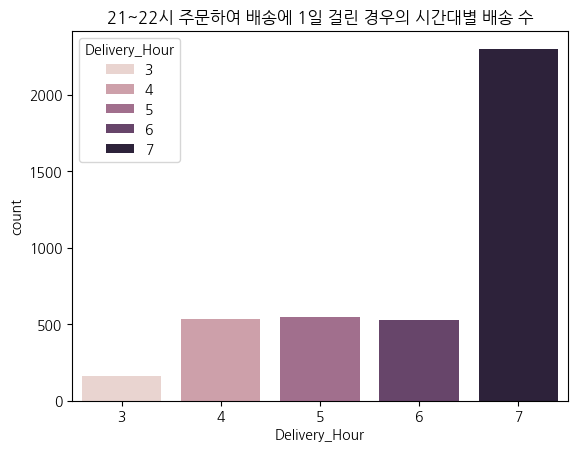

In [ ]:
# 21~22시 주문하여 배송에 1일 걸린 경우의 배송지연율(약 4000개 데이터) plot
sns.countplot(data = kurly_order_21[kurly_order_21['Delivery_diff_Order']=='1 days'], x = 'Delivery_Hour', hue='Delivery_Hour')
plt.title("21~22시 주문하여 배송에 1일 걸린 경우의 시간대별 배송 수")

In [ ]:
# 21~22시 주문하여 배송에 1일 걸린 경우의 배송지연율(약 4000개 데이터)
kurly_order_21[kurly_order_21['Delivery_diff_Order']=='1 days']['Delivery_Hour'].value_counts(normalize=True)

7    0.565015
5    0.133955
4    0.131011
6    0.129784
3    0.040236
Name: Delivery_Hour, dtype: float64

* (21시 이후 주문 & 익일 7시 이후 배송을 지연이라고 판단했을 때)
- 21시~22시에 주문한 경우
    - 배송에 2일이 걸릴 때 배송지연율은 약 4.8%
    - 배송에 1일이 걸릴 때 배송지연율은 약 57%
- 21시~22시에 주문하여 바로 다음 날 배송을 하려할 때 배송 지연이 굉장히 많다.

<ipython-input-80-09c19fe15f73>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = kurly_order_after22, x = 'Delivery_diff_Order', palette='Purples')


Text(0.5, 1.0, '22시 이후 주문시 도착까지 걸리는 일 수')

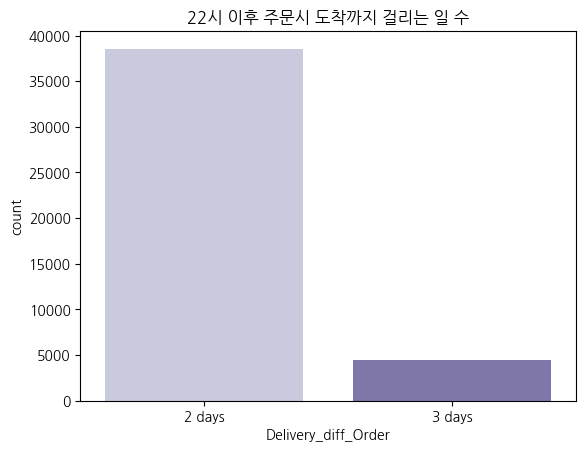

In [ ]:
# 22시 이후 주문 중 바로 다음날 배송해준 건수
kurly_order_after22 = kurly[kurly['Hour']==22 | 23]
sns.countplot(data = kurly_order_after22, x = 'Delivery_diff_Order', palette='Purples')
plt.title("22시 이후 주문시 도착까지 걸리는 일 수")

- 22시 이후 주문한 경우 모두 2일 이후 배송

- 정리(21시 이후 주문 & 익일 7시 이후 배송을 지연이라고 판단했을 때)
    1. 21시 ~ 22시에 주문한 경우 배송지연율 높다(약 7.7%).
    2. 우리 회사는 21시 전 주문 건만 익일새벽배송이 원칙.
    3. 21시 ~ 22시에 주문한 것 중 익일새벽배송이 존재(약 5.8%)
    4. 21시 ~ 22시에 주문한 것이 익일새벽배송일 때 배송지연율이 높음(약 57%)
    5. 21시 이후 주문에 대하여 익일새벽배송을 하려고 할 때의 프로세스 개선이 필요

## 상품에 따른 지연율


In [ ]:
item_delay = kurly.groupby("ItemMiddleName")['Delay_YN'].mean().reset_index()
item_delay

,ItemMiddleName,Delay_YN
0,곡물,0.039038
1,과일,0.038697
2,과자,0.038803
3,냉동,0.038494
4,생수,0.035534
5,수산,0.038437
6,신선,0.039628
7,양념,0.038472
8,음료,0.041167
9,즉석,0.040453


<Axes: xlabel='ItemMiddleName', ylabel='Delay_YN'>

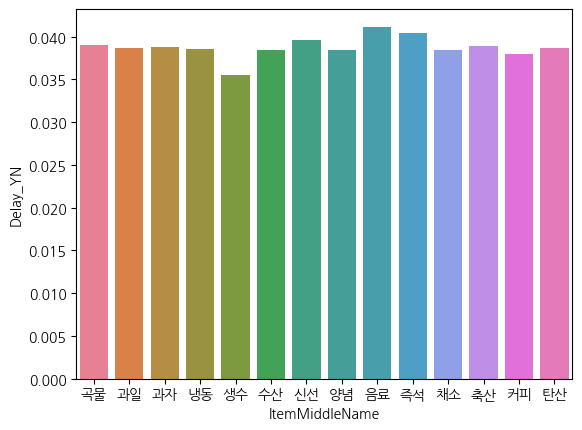

In [ ]:
sns.barplot(data = item_delay, x = 'ItemMiddleName', y='Delay_YN', hue= 'ItemMiddleName')

- 생수의 지연율이 낮다(평균 4.1% / 생수 3.78%)
- 비율 검정 결과 차이가 유의하지 않음

### 검정(z_test)

In [ ]:
## 생수과 나머지 ztest
# WeekdayName이 Saturday인 데이터와 아닌 데이터로 분리
delay_water = kurly[kurly['ItemMiddleName'] == '생수']['Delay_YN']
delay_not_water = kurly[kurly['ItemMiddleName'] != '생수']['Delay_YN']
# z-검정 실시
z_stat, p_value = ztest(delay_water, delay_not_water)
print(f'Z-statistic: {z_stat}, P-value: {p_value}')

Z-statistic: -1.0889235505938653, P-value: 0.27618759987861596


* p-value = 0.276으로 0.05보다 크므로 유의수준 5%에서 유의하지 않다.
생수의 배송지연율이 다른 상품과 다르다고 할 수 없다.